Arquivos carregados com sucesso!
--- Atraso por Região ---
          Taxa de Atraso  Qtd Pedidos
Region                               
Sudeste         0.835025          394
Sul             0.826531          392
Norte           0.825737          373
Nordeste        0.823529          391


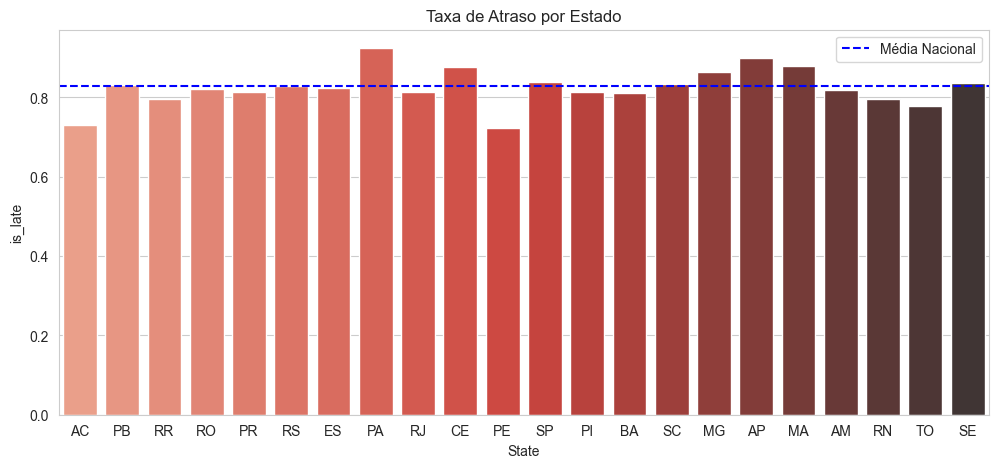

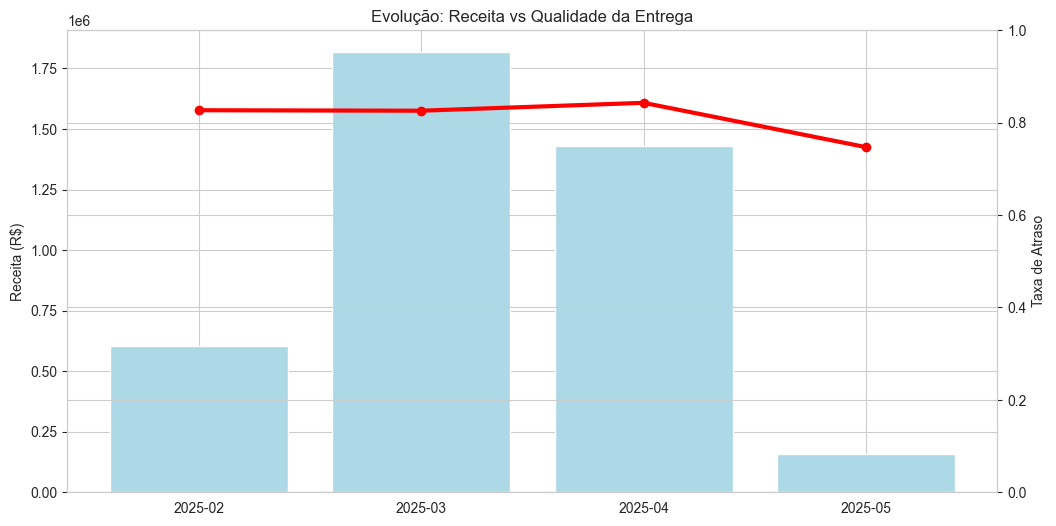

--- RELATÓRIO FINAL ---
Ticket Médio (Faturamento Real): R$ 2583.37
Tempo Médio de Entrega: 38.4 dias
Taxa de Atraso: 82.77%
Arquivo limpo salvo em: ../data/processed/orders_saneado.csv


In [6]:
# --- CÉLULA 1: Importação ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os

# Configuração visual
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# --- CÉLULA 2: Ingestão de Dados ---
# Ajustando o caminho para funcionar no Windows (Lendo da pasta ../data/raw)
base_path = '../data/raw/'

try:
    df_orders = pd.read_csv(os.path.join(base_path, 'FACT_Orders.csv'))
    df_customer = pd.read_csv(os.path.join(base_path, 'DIM_Customer.csv'))
    df_delivery = pd.read_csv(os.path.join(base_path, 'DIM_Delivery.csv'))
    df_shopping = pd.read_csv(os.path.join(base_path, 'DIM_Shopping.csv'))
    df_products = pd.read_csv(os.path.join(base_path, 'DIM_Products.csv'))
    print("Arquivos carregados com sucesso!")
except FileNotFoundError:
    print(f"ERRO: Não encontrei os arquivos em {base_path}. Verifique se moveu os CSVs para a pasta data/raw.")

# Ordenação
df_orders = df_orders.sort_values('Id').reset_index(drop=True)
df_customer = df_customer.sort_values('Id').reset_index(drop=True)
df_delivery = df_delivery.sort_values('Id').reset_index(drop=True)
df_shopping = df_shopping.sort_values('Id').reset_index(drop=True)

# --- CÉLULA 3: Tratamento e Join ---
# --- CÉLULA 3: Tratamento e Join (CORRIGIDO) ---
# Tratamento de datas
date_cols = ['D_Forecast', 'D_Date']
for col in date_cols:
    if col in df_delivery.columns:
        df_delivery[col] = pd.to_datetime(df_delivery[col], errors='coerce')

if 'Order_Date' in df_orders.columns:
    df_orders['Order_Date'] = pd.to_datetime(df_orders['Order_Date'], errors='coerce')

# Convertendo numéricos (Separado por tabela para evitar erro)
# 1. Na tabela de Pedidos
for col in ['Total', 'Subtotal']:
    if col in df_orders.columns:
        df_orders[col] = pd.to_numeric(df_orders[col], errors='coerce')

# 2. Na tabela de Entregas
if 'P_Sevice' in df_delivery.columns:
    df_delivery['P_Sevice'] = pd.to_numeric(df_delivery['P_Sevice'], errors='coerce')

# Merge (Juntando tudo)
df_master = pd.concat([
    df_orders.rename(columns={'Id': 'Order_ID'}),
    df_customer.drop('Id', axis=1),
    df_delivery.drop(['Id', 'Delivery_Id'], axis=1),
    df_shopping.drop(['Id', 'Item_ID'], axis=1)
], axis=1)

# Join Categoria
df_master = df_master.merge(
    df_products[['Product_Name', 'Category', 'Subcategory']],
    left_on='Product', right_on='Product_Name', how='left'
)

#print("Tabelas unidas com sucesso!")
#print(f"Colunas finais: {df_master.columns.tolist()}")

# Merge
df_master = pd.concat([
    df_orders.rename(columns={'Id': 'Order_ID'}),
    df_customer.drop('Id', axis=1),
    df_delivery.drop(['Id', 'Delivery_Id'], axis=1),
    df_shopping.drop(['Id', 'Item_ID'], axis=1)
], axis=1)

# Join Categoria
df_master = df_master.merge(
    df_products[['Product_Name', 'Category', 'Subcategory']],
    left_on='Product', right_on='Product_Name', how='left'
)

# --- CÉLULA 4: Saneamento (A "Limpeza") ---
mask_time_travel = df_master['D_Date'] < df_master['Order_Date']
mask_status_error = (df_master['Purchase_Status'] == 'Cancelado') & (df_master['Status'] == 'Entregue')

df_clean = df_master[~mask_time_travel & ~mask_status_error].copy()

# Feature Engineering
df_clean['lead_time'] = (df_clean['D_Date'] - df_clean['Order_Date']).dt.days
df_clean['is_late'] = df_clean['D_Date'] > df_clean['D_Forecast']

# --- CÉLULA 5: Resultados ---
# Ticket Médio Real (Apenas Vendas Válidas: Não Canceladas e Saneadas)
df_vendas_reais = df_clean[df_clean['Purchase_Status'] != 'Cancelado']

kpi_ticket = df_vendas_reais['Total'].mean()
kpi_lead = df_clean['lead_time'].mean()
kpi_atraso = df_clean['is_late'].mean()

# --- CÉLULA 6:  ---
# Análise por Região/Estado
df_geo = df_clean.groupby('Region')['is_late'].agg(['mean', 'count']).sort_values('mean', ascending=False)
df_geo.columns = ['Taxa de Atraso', 'Qtd Pedidos']

print("--- Atraso por Região ---")
print(df_geo)

# Visualização por Estado
plt.figure(figsize=(12, 5))
# Versão Corrigida
sns.barplot(
    x='State',
    y='is_late',
    hue='State',       # <--- Adicionamos isso (repetimos o X)
    data=df_clean,
    errorbar=None,
    palette='Reds_d',
    legend=False       # <--- E desligamos a legenda (pois seria redundante)
)
plt.axhline(y=df_clean['is_late'].mean(), color='blue', linestyle='--', label='Média Nacional')
plt.title('Taxa de Atraso por Estado')
plt.legend()
plt.show()

# --- CÉLULA 7:

# Criar coluna Mês-Ano
df_clean['Mes'] = df_clean['Order_Date'].dt.to_period('M')

# Agrupar
trend = df_clean.groupby('Mes').agg({
    'Total': 'sum',         # Receita
    'is_late': 'mean',      # Taxa de Atraso
    'lead_time': 'mean'     # Tempo de Entrega
})

# Plotar Receita vs Atraso
fig, ax1 = plt.subplots(figsize=(12, 6))

# Eixo 1: Receita (Barras)
ax1.bar(trend.index.astype(str), trend['Total'], color='lightblue', label='Receita')
ax1.set_ylabel('Receita (R$)')
ax1.tick_params(axis='y')

# Eixo 2: Atraso (Linha)
ax2 = ax1.twinx()
ax2.plot(trend.index.astype(str), trend['is_late'], color='red', marker='o', linewidth=3, label='% Atraso')
ax2.set_ylabel('Taxa de Atraso')
ax2.set_ylim(0, 1) # Escala de 0 a 100%

plt.title('Evolução: Receita vs Qualidade da Entrega')
plt.show()
print(f"--- RELATÓRIO FINAL ---")
print(f"Ticket Médio (Faturamento Real): R$ {kpi_ticket:.2f}")
print(f"Tempo Médio de Entrega: {kpi_lead:.1f} dias")
print(f"Taxa de Atraso: {kpi_atraso:.2%}")

# Salvar arquivo limpo
output_path = '../data/processed/orders_saneado.csv'
df_clean.to_csv(output_path, index=False)
print(f"Arquivo limpo salvo em: {output_path}")